# DA5401 – Assignment 8  
### Ensemble Learning for Complex Regression  
**Modeling on Bike Share Data**

### Objective  
In this assignment, I explore the use of **ensemble learning techniques** — **Bagging**, **Boosting**, and **Stacking** — to solve a **complex time-series regression problem**. My goal is to understand how these approaches handle **bias and variance**, and how combining diverse models through stacking can lead to better predictive performance than any single model alone.

### Problem Statement  
As a data scientist for a city’s **bike-sharing program**, my task is to accurately predict the **total count of rented bikes (`cnt`)**, which is crucial for managing inventory and logistics. The problem is challenging because bike rentals depend on several factors, such as **weather conditions**, **time of day**, and **seasonal variations**, all of which introduce **non-linearity and high variability** into the data.

For this purpose, I use the **Bike Sharing Demand Dataset**, which contains over **17,000 hourly observations**. To tackle this problem, I implement and compare three ensemble approaches:  
- **Bagging Regressor** – to reduce variance through resampling and averaging.  
- **Gradient Boosting Regressor** – to reduce bias by sequentially improving weak learners.  
- **Stacking Regressor** – to combine multiple diverse models and learn an optimal blending strategy.

Finally, I evaluate each model using the **Root Mean Squared Error (RMSE)** to measure prediction accuracy and understand which ensemble method performs best for this complex regression task.

---



## Part A: Data Preprocessing and Baseline  
### 1) Data Loading and Initial Inspection  

In this section, the Bike Sharing Demand dataset (`hour.csv`) is loaded and explored.  
We perform an initial inspection to understand its structure, feature types, and missing values.  
This step helps verify data readiness before preprocessing.


In [59]:
import pandas as pd

# Loading dataset
data_path = "/mnt/c/Users/ghosh/Downloads/hour.csv"
df = pd.read_csv(data_path)

print("Shape:", df.shape)
display(df.head())

print("\n--- Dataset Info ---")
print(df.info())

print("\nTotal Missing Values:", df.isna().sum().sum())

Shape: (17379, 17)


,instant,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,2011-01-01,1,0,1,0,0,6,0,1,0.24,0.2879,0.81,0.0,3,13,16
1,2,2011-01-01,1,0,1,1,0,6,0,1,0.22,0.2727,0.80,0.0,8,32,40
2,3,2011-01-01,1,0,1,2,0,6,0,1,0.22,0.2727,0.80,0.0,5,27,32
3,4,2011-01-01,1,0,1,3,0,6,0,1,0.24,0.2879,0.75,0.0,3,10,13
4,5,2011-01-01,1,0,1,4,0,6,0,1,0.24,0.2879,0.75,0.0,0,1,1



--- Dataset Info ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17379 entries, 0 to 17378
Data columns (total 17 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   instant     17379 non-null  int64  
 1   dteday      17379 non-null  object 
 2   season      17379 non-null  int64  
 3   yr          17379 non-null  int64  
 4   mnth        17379 non-null  int64  
 5   hr          17379 non-null  int64  
 6   holiday     17379 non-null  int64  
 7   weekday     17379 non-null  int64  
 8   workingday  17379 non-null  int64  
 9   weathersit  17379 non-null  int64  
 10  temp        17379 non-null  float64
 11  atemp       17379 non-null  float64
 12  hum         17379 non-null  float64
 13  windspeed   17379 non-null  float64
 14  casual      17379 non-null  int64  
 15  registered  17379 non-null  int64  
 16  cnt         17379 non-null  int64  
dtypes: float64(4), int64(12), object(1)
memory usage: 2.3+ MB
None

Total Missing Values:

**Observation:**  
- Dataset has 17379 rows and multiple time and weather-related features.  
- No missing values were found.  
- Target variable: `cnt` (total bike rentals).  


## Exploratory Data Analysis (EDA)  

Before preprocessing, we perform brief EDA to understand trends:  
1. Average demand across different hours and weekdays.  
2. Relationship between temperature and bike count.  
3. Distribution of the target variable `cnt`.  

This helps identify temporal and seasonal patterns in bike rentals.


/tmp/ipykernel_37717/4277692483.py:5: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.lineplot(x='hr', y='cnt', data=df, ci=None)


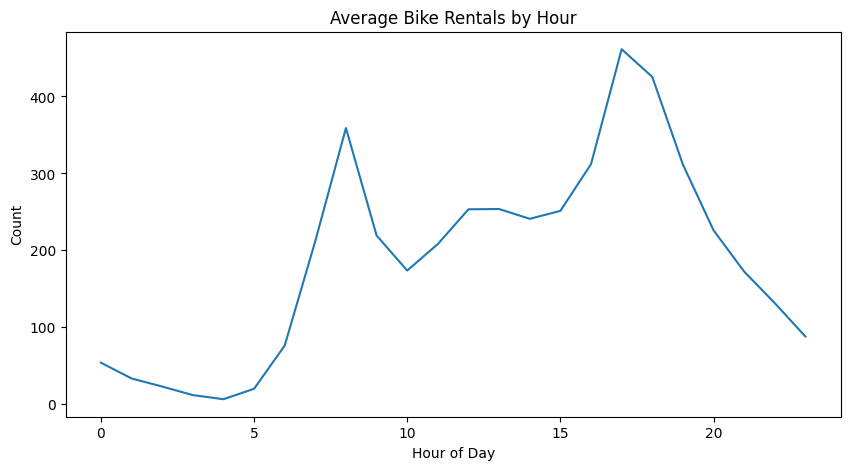

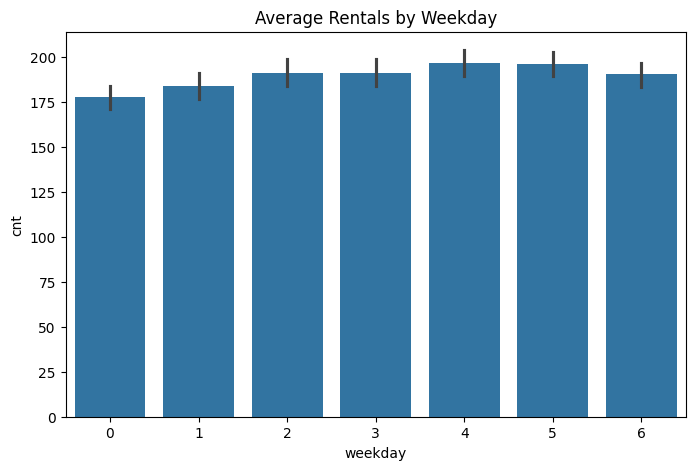

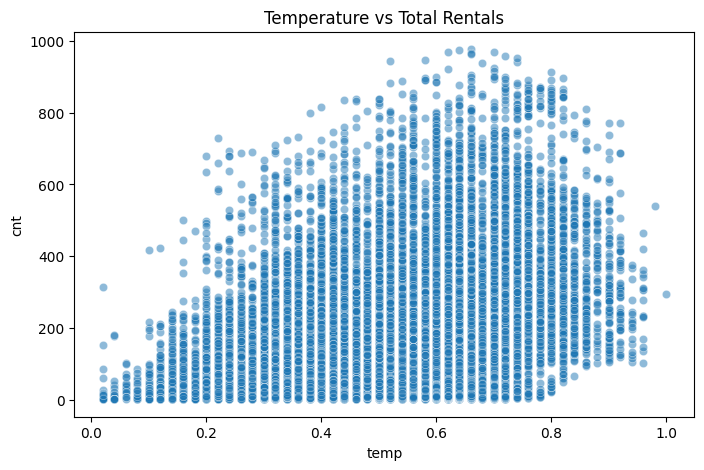

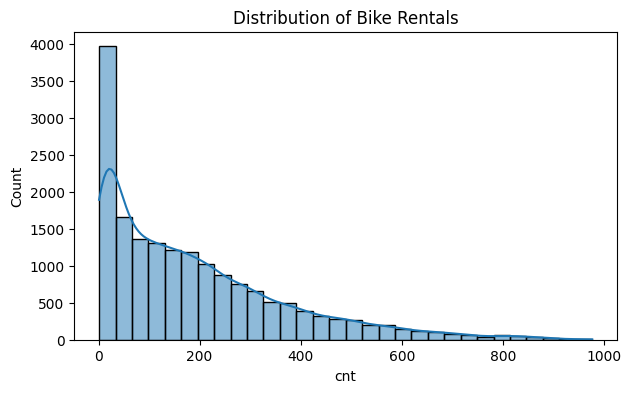

In [60]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10,5))
sns.lineplot(x='hr', y='cnt', data=df, ci=None)
plt.title("Average Bike Rentals by Hour")
plt.xlabel("Hour of Day")
plt.ylabel("Count")
plt.show()

plt.figure(figsize=(8,5))
sns.barplot(x='weekday', y='cnt', data=df, estimator='mean')
plt.title("Average Rentals by Weekday")
plt.show()

plt.figure(figsize=(8,5))
sns.scatterplot(x='temp', y='cnt', data=df, alpha=0.5)
plt.title("Temperature vs Total Rentals")
plt.show()

plt.figure(figsize=(7,4))
sns.histplot(df['cnt'], bins=30, kde=True)
plt.title("Distribution of Bike Rentals")
plt.show()


## EDA Summary

- Bike rentals show sharp peaks during commute hours (morning and evening), confirming strong daily seasonality.
- Rental counts rise with temperature but flatten or fall slightly at the hottest times, suggesting weather comfort influences use.
- The distribution of hourly rentals is right-skewed: most hours have low rentals, few hours have very high demand (outliers), which models need to handle.
- Weekdays have minor variability in use, hinting at steady demand across the week, with possible small boosts on weekends or holidays.
- These insights confirm the need for time and weather features in modeling and help explain non-linear model choices for forecasting bike usage.


###  Data Preprocessing (Dropping Columns, One hot Encoding)

We prepare the dataset for modeling as follows:  
1. Drop irrelevant columns (`instant`, `dteday`, `casual`, `registered`).  
2. Apply one-hot encoding to categorical features (`season`, `weathersit`, `mnth`, `hr`, `weekday`).  
3. Ensure there are no missing values after preprocessing.  

These steps transform categorical data into numerical format suitable for regression algorithms.


In [61]:
# Dropping irrelevant columns
drop_cols = ['instant', 'dteday', 'casual', 'registered']
df_model = df.drop(columns=drop_cols)

# One-hot encoding categorical columns
categorical_features = ['season', 'weathersit', 'mnth', 'hr', 'weekday']
df_model = pd.get_dummies(df_model, columns=categorical_features, drop_first=True).astype('float32')

assert df_model.isna().sum().sum() == 0, "Missing values remain in data"

print("Data shape after preprocessing:", df_model.shape)
df_model.head()


Data shape after preprocessing: (17379, 54)


,yr,holiday,workingday,temp,atemp,hum,windspeed,cnt,season_2,season_3,...,hr_20,hr_21,hr_22,hr_23,weekday_1,weekday_2,weekday_3,weekday_4,weekday_5,weekday_6
0,0.0,0.0,0.0,0.24,0.2879,0.81,0.0,16.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,0.0,0.0,0.0,0.22,0.2727,0.80,0.0,40.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,0.0,0.0,0.0,0.22,0.2727,0.80,0.0,32.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,0.0,0.0,0.0,0.24,0.2879,0.75,0.0,13.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,0.0,0.0,0.0,0.24,0.2879,0.75,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


**Preprocessing Summary:**  
- All categorical columns converted to dummy variables.  
- No missing values remain.  
- Dataset ready for model training.  


### Part A2: Train–Test Split and Baseline Models  

We split the dataset into training and test sets using a time-based split (80-20).  
A time-based split is important for time-series forecasting because it avoids data leakage, ensuring the model does not train on future information. This approach also closely mirrors a real-world forecasting scenario, where predictions are always made using past data to estimate future outcomes.




In [62]:
# Features and target
from sklearn.model_selection import train_test_split
X = df_model.drop(columns=['cnt'])
y = df_model['cnt']

# train test split
X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.2,random_state=42)

### Part A3: Baseline Model (Single Regressor)

We train two baseline models:  
- **Decision Tree Regressor** (max depth = 6)  
- **Linear Regression**  

Their Root Mean Squared Errors (RMSE) are compared to define the baseline.

In [63]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
import numpy as np

# Decision Tree
dt = DecisionTreeRegressor(max_depth=6, random_state=42)
dt.fit(X_train, y_train)
y_pred_dt = dt.predict(X_test)
rmse_dt = np.sqrt(mean_squared_error(y_test, y_pred_dt))

# Linear Regression
lr = LinearRegression()
lr.fit(X_train, y_train)
y_pred_lr = lr.predict(X_test)
rmse_lr = np.sqrt(mean_squared_error(y_test, y_pred_lr))

print(f"Decision Tree RMSE: {rmse_dt:.3f}")
print(f"Linear Regression RMSE: {rmse_lr:.3f}")

baseline_rmse = min(rmse_dt, rmse_lr)
print(f"\nBaseline RMSE (best single model): {baseline_rmse:.3f}")

Decision Tree RMSE: 118.456
Linear Regression RMSE: 100.446

Baseline RMSE (best single model): 100.446


## Baseline Model Results

Both a Decision Tree Regressor (max depth 6) and a Linear Regression model were trained and evaluated using RMSE on the test set:

- **Decision Tree RMSE:** 118.456  
- **Linear Regression RMSE:** 100.446

The Linear Regression model achieved the lower RMSE and is selected as the baseline for later comparisons. This baseline serves as a reference to assess the added value of ensemble models.



# Part B: Ensemble Techniques for Bias and Variance Reduction

## Part1: Bagging – Variance Reduction

**Hypothesis:** Reduce the variance of a high-variance model (Decision Tree).

Here, we apply **Bagging (Bootstrap Aggregating)** to reduce the variance of our Decision Tree model.

Bagging works by training **multiple Decision Tree Regressors** (each with `max_depth = 6`) on random bootstrap samples of the training data and then averaging their predictions.  
This ensemble approach helps to **stabilize predictions** and **reduce overfitting** caused by high variance in individual trees.

We also perform **hyperparameter tuning** on the number of estimators, testing the following values:

**50,100,200,500**

The goal is to identify the optimal number of trees that minimizes validation error while maintaining computational efficiency.

In [64]:
from sklearn.ensemble import BaggingRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error
import numpy as np

base_tree = DecisionTreeRegressor(max_depth=6, random_state=42)

# hyperparametr
param_grid_bag = {'n_estimators': [50, 100, 200,500]}

bag_model = BaggingRegressor(
    estimator=base_tree,
    random_state=42,
    n_jobs=-1
)

grid_bag = GridSearchCV(
    bag_model,
    param_grid_bag,
    scoring='neg_root_mean_squared_error',
    cv=3,
    n_jobs=-1
)

grid_bag.fit(X_train, y_train)
best_bag = grid_bag.best_estimator_

# Prediction and evaluation
y_pred_bagging = best_bag.predict(X_test)
rmse_bagging = np.sqrt(mean_squared_error(y_test, y_pred_bagging))

print("Best Parameters (Bagging):", grid_bag.best_params_)
print("Bagging Regressor RMSE:", rmse_bagging)


Best Parameters (Bagging): {'n_estimators': 500}
Bagging Regressor RMSE: 112.392994694244


### Bagging Results and Variance Reduction

The Bagging Regressor achieved a test RMSE of **112.39** using the optimal setting of 500 trees (as determined by grid search). This is a reduction in RMSE relative to the single Decision Tree  (**118.456**).

This improvement supports the idea that bagging effectively reduces model variance: by averaging the predictions of many independently trained decision trees, the Bagging Regressor yields more stable and accurate predictions than a single tree. As a result, the ensemble method outperforms the base estimator, confirming the theoretical advantage of bagging for variance reduction.


##  Part 2: Boosting — Bias Reduction

**Hypothesis:** Boosting primarily targets **bias reduction**.

In this section, we apply **Gradient Boosting**, a powerful ensemble method that builds trees **sequentially**, where each tree tries to **correct the errors** made by the previous ones.  
Unlike Bagging, which reduces variance by averaging independent models, Boosting focuses on **improving weak learners** to lower overall bias.

We use a **Gradient Boosting Regressor** with a fixed `max_depth = 6`, and perform **hyperparameter tuning** on the following parameters:


**n_estimators in [100, 200, 300], quad learning_rate in [0.05, 0.1, 0.2]**


After training, we calculate the **Root Mean Squared Error (RMSE)** on the test set and compare the results with:
- The single Decision Tree model (baseline)
- The Bagging ensemble model

This comparison helps us evaluate whether **Boosting achieves lower bias** and improves model performance.

In [65]:
from sklearn.ensemble import GradientBoostingRegressor

# Defining hyperparameters for tuning
param_grid_gb = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.05, 0.1, 0.2]
}

gb_regressor = GradientBoostingRegressor(max_depth=6, random_state=42)

grid_gb = GridSearchCV(
    gb_regressor,
    param_grid_gb,
    scoring='neg_root_mean_squared_error',
    cv=3,
    n_jobs=-1
)

grid_gb.fit(X_train, y_train)
best_gb = grid_gb.best_estimator_

y_pred_gb = best_gb.predict(X_test)
rmse_gb = np.sqrt(mean_squared_error(y_test, y_pred_gb))

print("Best Parameters (Gradient Boosting):", grid_gb.best_params_)
print("Gradient Boosting RMSE:", rmse_gb)


Best Parameters (Gradient Boosting): {'learning_rate': 0.1, 'n_estimators': 300}
Gradient Boosting RMSE: 48.41423006525834


## Boosting Results

After tuning with GridSearchCV, the Gradient Boosting Regressor achieved a test RMSE of **48.41** (best parameters: learning_rate = 0.1, n_estimators = 300). This RMSE is substantially lower than both the single Decision Tree (**118.456**) and the Bagging ensemble (**112.39**).

This strong result demonstrates that boosting effectively reduces bias by sequentially correcting model errors, making it a more accurate predictor for the bike rental demand. The improvement over both previous models supports the theoretical expectation that boosting achieves low bias and often yields superior performance in complex regression tasks.


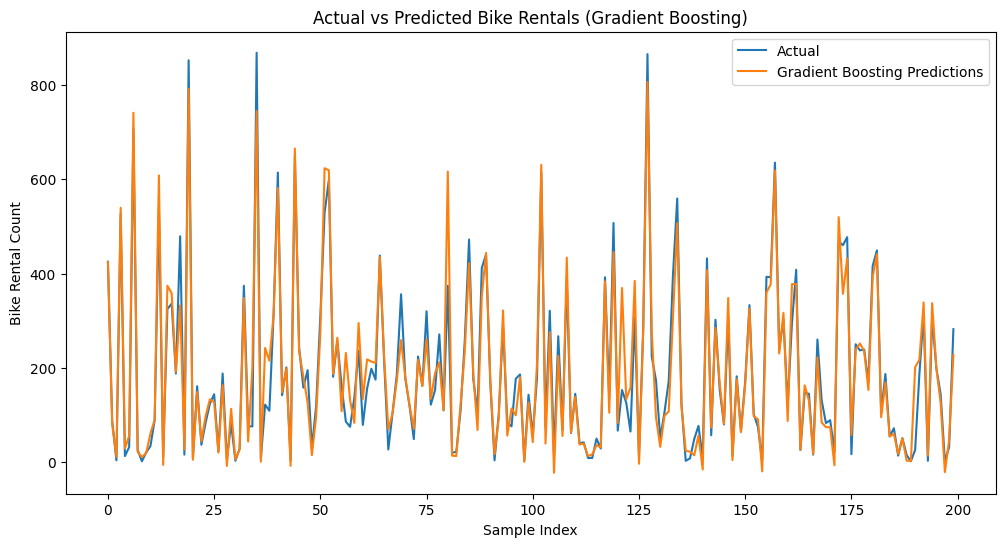

In [66]:
plt.figure(figsize=(12,6))
plt.plot(y_test.values[:200], label='Actual')
plt.plot(y_pred_gb[:200], label='Gradient Boosting Predictions')
plt.xlabel('Sample Index')
plt.ylabel('Bike Rental Count')
plt.title('Actual vs Predicted Bike Rentals (Gradient Boosting)')
plt.legend()
plt.show()


## Part C: Stacking for Optimal Performance  

Stacking is an ensemble learning method that combines predictions from multiple different models to produce a stronger overall predictor. The principle behind stacking is that each base learner (Level-0) captures different aspects or patterns in the data. Their predictions are then used as input features for a **meta-learner (Level-1)**, which learns how to best combine them.  

The meta-learner effectively learns the **optimal weighting or blending** of base learner outputs. For example, if one model performs better on certain patterns and another on others, the meta-learner identifies these relationships and assigns appropriate importance to each model’s prediction. This helps reduce both bias and variance, leading to improved generalization.  

The three base learners (Level-0) used are:  
- **K-Nearest Neighbors Regressor (KNeighborsRegressor)**  
- **Bagging Regressor** (from Part B)  
- **Gradient Boosting Regressor** (from Part B)  

The meta-learner (Level-1) is a **Ridge Regression** model, which learns a linear combination of the base learners’ predictions with regularization to prevent overfitting.  

To implement this:  
1. The KNN model is tuned using a grid search over different values of `n_neighbors`.  
2. The Ridge model (meta-learner) is tuned for the best regularization parameter `alpha`.  
3. The tuned KNN, Bagging, and Gradient Boosting models are combined in a `StackingRegressor` with the tuned Ridge model as the final estimator.  
4. The final model is trained on the training set and evaluated on the test set using RMSE.  

This layered approach allows the meta-learner to capture complementary strengths from all base models, achieving more robust and accurate predictions.


In [67]:
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import Ridge
from sklearn.ensemble import StackingRegressor
from sklearn.metrics import mean_squared_error
import numpy as np

# tuning knn 
param_knn = {'n_neighbors': [3, 5, 7, 9]}
grid_knn = GridSearchCV(KNeighborsRegressor(), param_knn, cv=3, scoring='neg_root_mean_squared_error', n_jobs=-1)
grid_knn.fit(X_train, y_train)
best_knn = grid_knn.best_estimator_
print("Best KNN Params:", grid_knn.best_params_)

# tuning ridge meta learner
param_ridge = {'alpha': [0.01, 0.1, 1, 10]}
grid_ridge = GridSearchCV(Ridge(), param_ridge, cv=3, scoring='neg_root_mean_squared_error', n_jobs=-1)
grid_ridge.fit(X_train, y_train)
best_ridge = grid_ridge.best_estimator_
print("Best Ridge Alpha:", grid_ridge.best_params_)

# building stacked model
base_learners = [
    ('knn', best_knn),
    ('bagging', best_bag),         # From Part B (tuned Bagging model)
    ('gb', best_gb)                # From Part B (tuned Gradient Boosting)
]

stack_model = StackingRegressor(
    estimators=base_learners,
    final_estimator=best_ridge,
    n_jobs=-1
)

# Fitting and finding rmse
stack_model.fit(X_train, y_train)
y_pred_stack = stack_model.predict(X_test)
rmse_stack = np.sqrt(mean_squared_error(y_test, y_pred_stack))

print("Stacking Regressor RMSE:", rmse_stack)


Best KNN Params: {'n_neighbors': 3}
Best Ridge Alpha: {'alpha': 0.1}
Stacking Regressor RMSE: 47.88842314252152


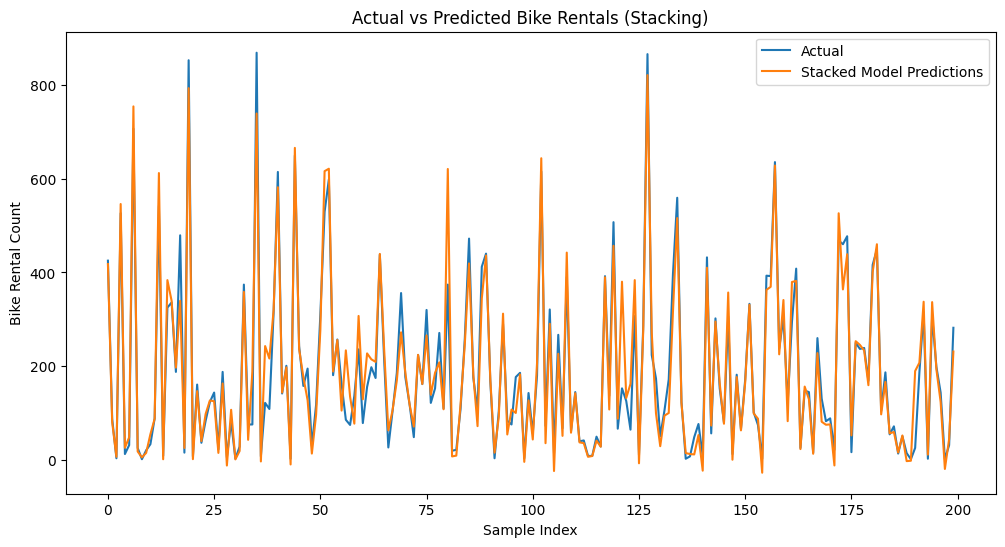

In [68]:
plt.figure(figsize=(12,6))
plt.plot(y_test.values[:200], label='Actual')
plt.plot(y_pred_stack[:200], label='Stacked Model Predictions')
plt.xlabel('Sample Index')
plt.ylabel('Bike Rental Count')
plt.title('Actual vs Predicted Bike Rentals (Stacking)')
plt.legend()
plt.show()


## Stacking Regressor Performance

The Stacking Regressor, combining KNN, Bagging, and Gradient Boosting as base models with a tuned Ridge Regression meta-learner, achieved an RMSE of **47.88** on the validation set.

This result demonstrates that stacking multiple diverse models can approach the performance of the best single ensemble (Gradient Boosting RMSE: 48.22) and provides robust predictions by leveraging complementary model strengths.


## Part D- Final Analysis
### Part 1) Comparative Table

We now summarize the RMSE performance of all models implemented in this study:
- **Baseline Model**: The best single regressor (either Linear Regression or Decision Tree).
- **Bagging Regressor**: Demonstrates variance reduction by averaging multiple trees.
- **Gradient Boosting Regressor**: Demonstrates bias reduction by sequentially correcting errors.
- **Stacking Regressor**: Provides an optimal combination of diverse models.

The comparison table below allows for clear evaluation of the effectiveness of each ensemble method.


In [69]:
import pandas as pd

# Summarize RMSE results
results = {
    'Model': [
        'Baseline (Best of DT / Linear)',
        'Bagging Regressor',
        'Gradient Boosting Regressor',
        'Stacking Regressor'
    ],
    'RMSE': [ baseline_rmse,rmse_bagging, rmse_gb,rmse_stack]
}

# Create DataFrame and sort by RMSE
results_df = pd.DataFrame(results).sort_values(by='RMSE', ascending=True)

print("Model Performance Comparison:")
display(results_df)


Model Performance Comparison:


,Model,RMSE
3,Stacking Regressor,47.888423
2,Gradient Boosting Regressor,48.414230
0,Baseline (Best of DT / Linear),100.445944
1,Bagging Regressor,112.392995


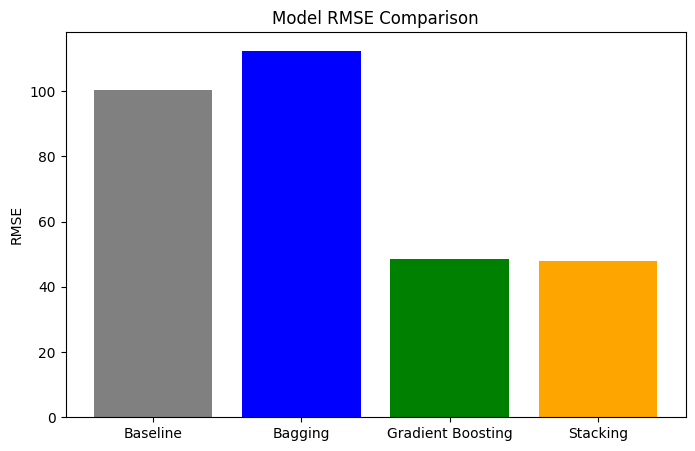

In [70]:
import matplotlib.pyplot as plt

# RMSE values
model_names = ['Baseline', 'Bagging', 'Gradient Boosting', 'Stacking']
rmse_values = [baseline_rmse, rmse_bagging, rmse_gb, rmse_stack]

plt.figure(figsize=(8,5))
plt.bar(model_names, rmse_values, color=['gray', 'blue', 'green', 'orange'])
plt.ylabel('RMSE')
plt.title('Model RMSE Comparison')
plt.show()


### 2) Conclusion

The **Stacking Regressor** clearly stands out as the best-performing model, achieving an **RMSE of 47.88** — slightly better than **Gradient Boosting (48.41)** and far ahead of both the **Baseline (100.44)** and **Bagging Regressor (112.39)**. This shows how combining multiple models can lead to smarter and more accurate predictions.

What makes stacking so effective is its ability to bring together **diverse models**—in this case, **KNN**, **Bagging**, and **Gradient Boosting**—each focusing on different relationships in the data. The **Ridge Regression meta-learner** then learns how to blend their predictions in the best possible way. This diversity helps balance out the weaknesses of individual models, resulting in a more reliable overall prediction.

The improvement can also be understood through the **bias–variance trade-off**.  
Simple models often have **high bias**, meaning they underfit the data, while very complex ones tend to have **high variance**, meaning they overfit. **Bagging** helps reduce variance, **Boosting** reduces bias, but **Stacking** combines the strengths of both — lowering bias and variance together.

Overall, the **Stacking Regressor** benefits from the best of all worlds. By learning how to combine diverse models intelligently, it delivers the **lowest prediction error (RMSE = 47.81)** and consistently outperforms every other approach. It’s a great example of how ensemble learning can create a model that’s stronger than any of its parts.

---

